In [26]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import random as rn

In [ ]:
RANDOM_SEED = 42
TRAINING_SAMPLE = 200000
VALIDATE_SIZE = 0.2

# setting seeds
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [3]:
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [11]:
df.columns = map(str.lower, df.columns)
df.rename(columns={'class': 'label'}, inplace=True)
df.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v21,v22,v23,v24,v25,v26,v27,v28,label,log10_amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,2.174990
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,0.429754
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,2.578249
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,2.091667
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,1.845036


In [7]:
df['log10_amount'] = np.log10(df.amount + 0.00001)

In [ ]:
RATIO_TO_FRAUD = 10

# dropping redundant columns
df = df.drop(['time', 'amount'], axis=1)

fraud = df[df['label'] == 1]
clean = df[df['label'] == 0]

clean_undersampled = clean.sample(
    int(len(fraud) * RATIO_TO_FRAUD),
    random_state=RANDOM_SEED
)

visualisation_initial = pd.concat([fraud, clean_undersampled])
column_names = list(visualisation_initial.drop('label', axis=1).columns)

features, labels = visualisation_initial.drop('label', axis=1).values, \
                   visualisation_initial.label.values

In [ ]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

def tsne_scatter(features, labels, dimensions=2, save_as='graph.png'):
    features_embedded = TSNE(n_components=dimensions, random_state=RANDOM_SEED).fit_transform(features)
    
    fig, ax = plt.subplots(figsize=(8,8))

    if dimensions == 3: ax = fig.add_subplot(111, projection='3d')

    ax.scatter(
        *zip(*features_embedded[np.where(labels==1)]),
        marker='o',
        color='r',
        s=2,
        alpha=0.7,
        label='Fraud'
    )
    ax.scatter(
        *zip(*features_embedded[np.where(labels==0)]),
        marker='o',
        color='g',
        s=2,
        alpha=0.3,
        label='Clean'
    )

    plt.legend(loc='best')
    plt.savefig(save_as);
    plt.show;

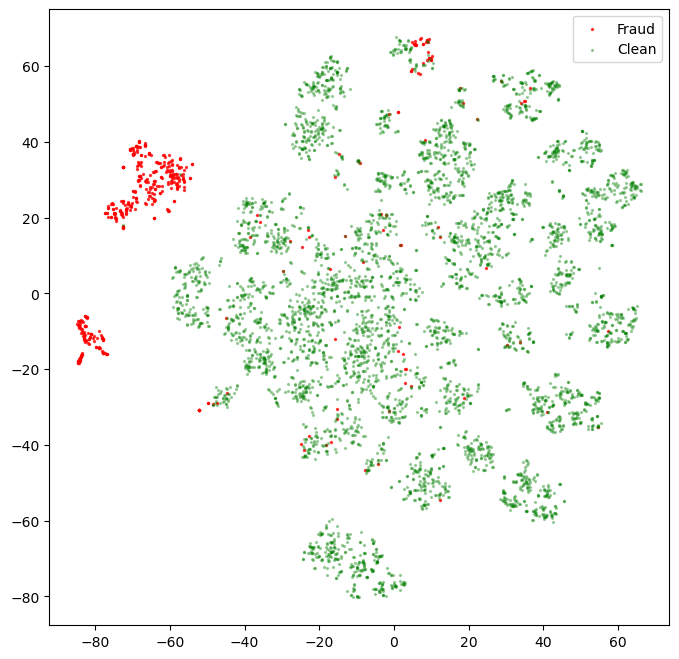

In [14]:
tsne_scatter(features, labels, dimensions=2, save_as='tsne_initial_2d.png')

In [ ]:
clean = clean.sample(frac=1).reset_index(drop=True)

X_train = clean.iloc[:TRAINING_SAMPLE].drop('label', axis=1)

X_test = pd.concat([clean.iloc[TRAINING_SAMPLE:], fraud]).sample(frac=1)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_validate = train_test_split(X_train, 
                                       test_size=VALIDATE_SIZE, 
                                       random_state=RANDOM_SEED)

X_test, y_test = X_test.drop('label', axis=1).values, X_test.label.values

In [ ]:
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])

In [19]:
pipeline.fit(X_train);

In [20]:
X_train_transformed = pipeline.transform(X_train)
X_validate_transformed = pipeline.transform(X_validate)

In [22]:
import seaborn as sns

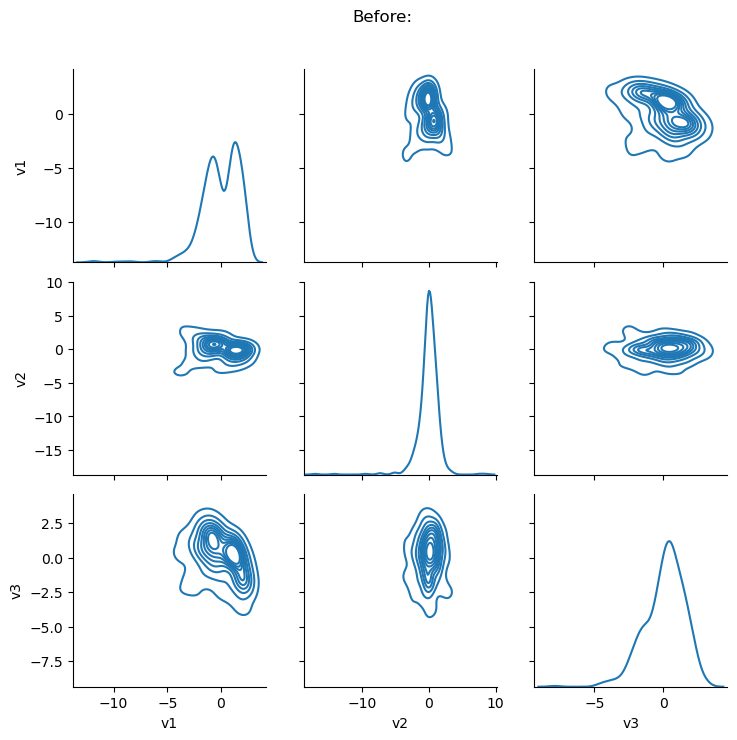

In [24]:
g = sns.PairGrid(X_train.iloc[:,:3].sample(600, random_state=RANDOM_SEED))
plt.subplots_adjust(top=0.9)
g.figure.suptitle('Before:')
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot);

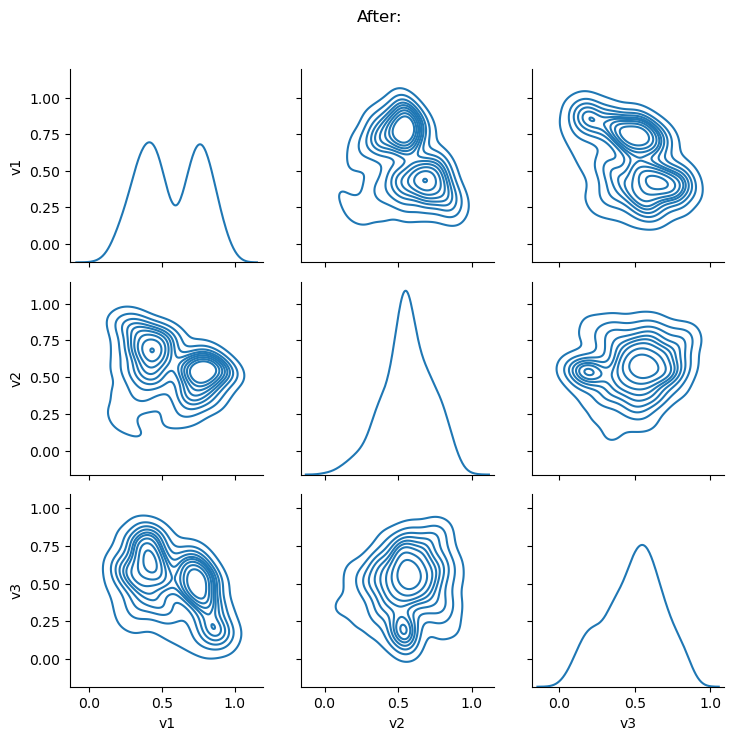

In [25]:
g = sns.PairGrid(pd.DataFrame(X_train_transformed, columns=column_names).iloc[:,:3].sample(600, random_state=RANDOM_SEED))
plt.subplots_adjust(top=0.9)
g.figure.suptitle('After:')
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot);

In [ ]:
input_dim = X_train_transformed.shape[1]
BATCH_SIZE = 256
EPOCHS = 100

class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.ELU(),
            nn.Linear(input_dim, 16),
            nn.ELU(),
            nn.Linear(16, 8),
            nn.ELU(),
            nn.Linear(8, 4),
            nn.ELU(),
            nn.Linear(4, 2),
            nn.ELU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(2, 4),
            nn.ELU(),
            nn.Linear(4, 8),
            nn.ELU(),
            nn.Linear(8, 16),
            nn.ELU(),
            nn.Linear(16, input_dim),
            nn.ELU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [29]:
autoencoder = Autoencoder(input_dim)

In [ ]:
from torch import optim

criterion = nn.MSELoss()  
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

In [ ]:
X_train_tensor = torch.tensor(X_train_transformed, dtype=torch.float32)
X_val_tensor = torch.tensor(X_validate_transformed, dtype=torch.float32)

criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

for epoch in range(EPOCHS):
    autoencoder.train()
    train_loss = 0.0
    
    indices = torch.randperm(X_train_tensor.size(0))
    
    for i in range(0, len(indices), BATCH_SIZE):
        batch_indices = indices[i:i+BATCH_SIZE]
        inputs = X_train_tensor[batch_indices]
            
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)  
    
    avg_train_loss = train_loss / len(X_train_tensor)
    
    autoencoder.eval()
    with torch.no_grad():
        val_outputs = autoencoder(X_val_tensor)
        val_loss = criterion(val_outputs, X_val_tensor).item()
    
    print(f'Epoch [{epoch+1}/{EPOCHS}] '
          f'Train Loss: {avg_train_loss:.4f}, '
          f'Val Loss: {val_loss:.4f}')

Epoch [1/100] Train Loss: 0.0358, Val Loss: 0.0155
Epoch [2/100] Train Loss: 0.0150, Val Loss: 0.0146
Epoch [3/100] Train Loss: 0.0140, Val Loss: 0.0136
Epoch [4/100] Train Loss: 0.0133, Val Loss: 0.0131
Epoch [5/100] Train Loss: 0.0129, Val Loss: 0.0128
Epoch [6/100] Train Loss: 0.0128, Val Loss: 0.0128
Epoch [7/100] Train Loss: 0.0127, Val Loss: 0.0127
Epoch [8/100] Train Loss: 0.0126, Val Loss: 0.0126
Epoch [9/100] Train Loss: 0.0125, Val Loss: 0.0125
Epoch [10/100] Train Loss: 0.0124, Val Loss: 0.0123
Epoch [11/100] Train Loss: 0.0122, Val Loss: 0.0120
Epoch [12/100] Train Loss: 0.0119, Val Loss: 0.0118
Epoch [13/100] Train Loss: 0.0117, Val Loss: 0.0117
Epoch [14/100] Train Loss: 0.0116, Val Loss: 0.0115
Epoch [15/100] Train Loss: 0.0115, Val Loss: 0.0114
Epoch [16/100] Train Loss: 0.0114, Val Loss: 0.0113
Epoch [17/100] Train Loss: 0.0113, Val Loss: 0.0113
Epoch [18/100] Train Loss: 0.0112, Val Loss: 0.0112
Epoch [19/100] Train Loss: 0.0111, Val Loss: 0.0111
Epoch [20/100] Train 

In [43]:
X_test_transformed = pipeline.transform(X_test)

X_test_tensor = torch.tensor(X_test_transformed, dtype=torch.float32)

device = torch.device('cpu')
X_test_tensor = X_test_tensor.to(device)
autoencoder.to(device)  
autoencoder.eval()

with torch.no_grad():
    reconstructions = autoencoder(X_test_tensor)

reconstructions= reconstructions.cpu().numpy()

c:\Users\Kusha\OneDrive\Desktop\GAN\Gan_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  warnings.warn(


In [37]:
mse = np.mean(np.power(X_test_transformed - reconstructions, 2), axis=1)

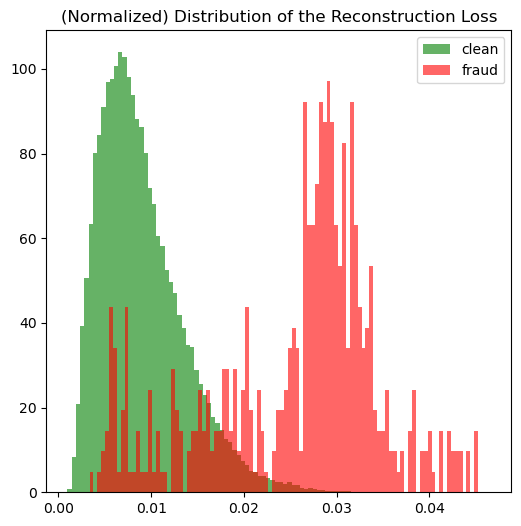

In [39]:
clean = mse[y_test==0]
fraud = mse[y_test==1]

fig, ax = plt.subplots(figsize=(6,6))

ax.hist(clean, bins=100, density=True, label="clean", alpha=.6, color="green")
ax.hist(fraud, bins=100, density=True, label="fraud", alpha=.6, color="red")

plt.title("(Normalized) Distribution of the Reconstruction Loss")
plt.legend()
plt.show()